In [1]:
#Se cargan las bibliotecas necesarias 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage. feature import hog
import matplotlib.image as mpimg

from sklearn import svm
import numpy as np
import joblib
from skimage.feature import hog
from sklearn.utils import shuffle
import sys
import argparse
import random

In [2]:
import glob

pedestrian = glob.glob("data_svm/Pedestrian/*.png")
no_pedestrian= glob.glob("data_svm/nonPedestrian/*.png")

In [3]:
len(pedestrian)

902

In [4]:
len(no_pedestrian)

1212

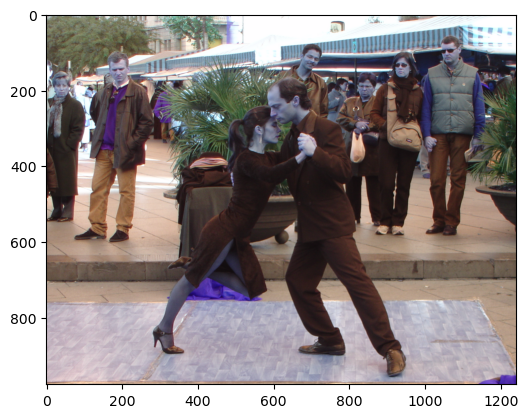

In [5]:
#Se muestra imagen con un peaton
img_color= cv2.imread(pedestrian[1])
plt.imshow(img_color)

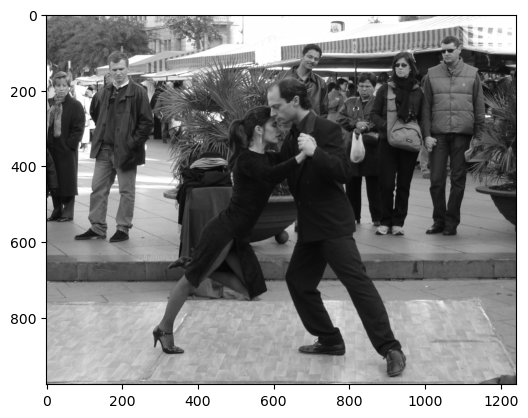

In [6]:
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap ="gray")

In [7]:
def crop_centre(img):
    h, w, _ = img.shape
    l = int((w - 64)/2)
    t = int((h - 128)/2)

    crop = img[t:t+128, l:l+64]
    return crop

In [8]:
cropped = crop_centre(img_color)
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
features,hog_img = hog(gray, orientations=11, 
                       pixels_per_cell= (16,16),
                       cells_per_block=(2,2),
                       transform_sqrt= False,
                       visualize = True,
                       feature_vector= True)

In [9]:
print('Dimensiones de los features: ', features.shape)
print('Dimensiones de hot imágenes: ', hog_img.shape)

Dimensiones de los features:  (924,)
Dimensiones de hot imágenes:  (128, 64)


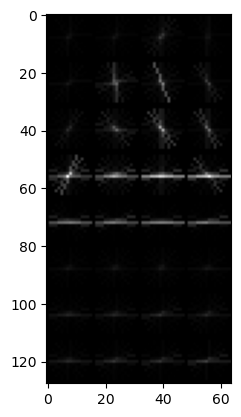

In [10]:
plt.imshow(hog_img,cmap ="gray")

In [11]:
pedestrian_hog_accum = []

for i  in pedestrian:
    img_color = mpimg.imread(i)
    cropped = crop_centre(img_color)
    img_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    pedestrian_hog_feature  = hog(img_gray,
                                orientations =11,
                                pixels_per_cell= (16,16),
                                cells_per_block=(2,2),
                                transform_sqrt= False,
                                visualize = False,
                                feature_vector= True)
    pedestrian_hog_accum. append (pedestrian_hog_feature)

In [12]:
X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)
Y_pedestrian = np.ones(len(X_pedestrian))

In [13]:
print('Dimensiones de X pedestrian: ', X_pedestrian.shape)
print('Dimensiones de Y pedestrian: ', Y_pedestrian.shape)

Dimensiones de X pedestrian:  (902, 924)
Dimensiones de Y pedestrian:  (902,)


In [14]:
nopedestrian_hog_accum = []

for i  in no_pedestrian:
    img_color = mpimg.imread(i)
    cropped = crop_centre(img_color)
    img_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    nopedestrian_hog_feature  = hog(img_gray,
                                orientations =11,
                                pixels_per_cell= (16,16),
                                cells_per_block=(2,2),
                                transform_sqrt= False,
                                visualize = False,
                                feature_vector= True)

    nopedestrian_hog_accum. append (nopedestrian_hog_feature)

In [15]:
X_nopedestrian = np.vstack(nopedestrian_hog_accum).astype(np.float64)
Y_nopedestrian = np.zeros(len(X_nopedestrian))

In [16]:
print('Dimensiones de X nonPedestrian: ', X_nopedestrian.shape)
print('Dimensiones de Y nonPedestrian: ', Y_nopedestrian.shape)

Dimensiones de X nonPedestrian:  (1212, 924)
Dimensiones de Y nonPedestrian:  (1212,)


In [17]:
X = np.vstack((X_pedestrian,X_nopedestrian))
X.shape

(2114, 924)

In [38]:
Y = np.hstack((Y_pedestrian,Y_nopedestrian))
Y.shape

(2114,)

In [40]:
#Se generan los datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [41]:
print('Dimensiones de X train: ', X_train.shape)
print('Dimensiones de X test: ', X_test.shape)

Dimensiones de X train:  (1691, 924)
Dimensiones de X test:  (423, 924)


In [44]:
print('Dimensiones de y train: ', y_train.shape)
print('Dimensiones de y test: ', y_test.shape)

Dimensiones de y train:  (1691,)
Dimensiones de y test:  (423,)


In [45]:
from sklearn.svm import SVC

svc_model= SVC()
svc_model.fit(X_train, y_train)

SVC()

In [46]:
y_predict = svc_model.predict(X_test)

<AxesSubplot:>

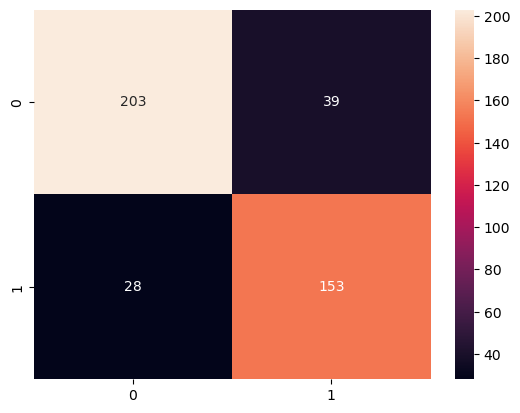

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap (cm, annot= True , fmt= "d")

In [48]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86       242
         1.0       0.80      0.85      0.82       181

    accuracy                           0.84       423
   macro avg       0.84      0.84      0.84       423
weighted avg       0.84      0.84      0.84       423



In [49]:
param_grid = {'C': [0.1,1,10,100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel':['rbf']}

In [50]:
from sklearn.model_selection import GridSearchCV

grid= GridSearchCV(SVC(),param_grid,refit= True,verbose =4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.572 total time=   0.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   1.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   0.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   1.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.574 total time=   1.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.732 total time=   0.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.707 total time=   0.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.713 total time=   1.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.725 total time=   1.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.722 total time=   1.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.572 total time=   0.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.574 total time=   1.2s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.574 total time=   0.9s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.574 total time=   1.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.574 total time=   0.9s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.844 total time=   0.8s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.778 total time=   0.8s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.802 total time=   0.8s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.828 total time=   0.9s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.757 total time=   0.8s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.811 total time=   0.7s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.713 total time=   0.8s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.751 total time=   0.7s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [51]:
print('El mejor parámetro para nuestro set es: ', grid.best_params_)
print('El mejor estimador para nuestro set es: ', grid.best_estimator_)

El mejor parámetro para nuestro set es:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
El mejor estimador para nuestro set es:  SVC(C=1, gamma=0.1)


In [52]:
grid_predictions = grid.predict(X_test)

<AxesSubplot:>

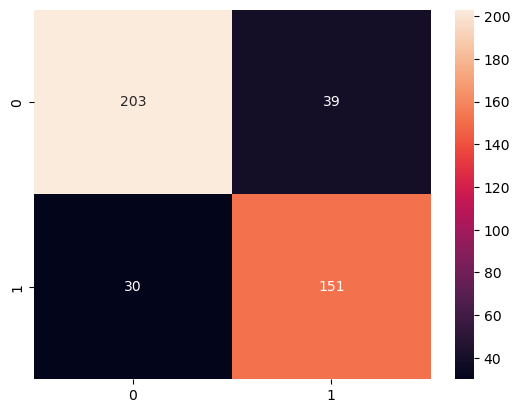

In [53]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt= "d")

In [54]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       242
         1.0       0.79      0.83      0.81       181

    accuracy                           0.84       423
   macro avg       0.83      0.84      0.83       423
weighted avg       0.84      0.84      0.84       423

